The code below was taken from the link below, and may even have a prior source.
There are some additional commented notes added for clarification purposes.

https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

C:\Users\jkhanlian\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import handwritten training data set
#transform/clean

def load_data():
    
    #get MNIST hand written number dataset from curated keras datasets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    #normalize the pixel values
    #grayscale pixel values range from 0 (black) to 255 (white)
    #now all of our pixel values will range from -1 (black) to 1 (white)
    #normalizing input values is a practice done that seems to make training neural nets easier
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 60,000 training examples; one in each row; with 784 columns of unrolled pixel inputs
    x_train = x_train.reshape(60000, 784)
    
    return (x_train, y_train, x_test, y_test)

#run function to load data
(X_train, y_train, X_test, y_test)=load_data()

#verify shape of training data
print(X_train.shape)

#first training example 
#first set of pixel values that represent a picture of a hand written number
print(X_train[1,:])

(60000, 784)
[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.        

 -1.         -1.         -1.         -1.        ]


In [3]:
#Define the Adam Optimizer parameter for updating weights
#Adam is an adaptive-rate learning algorithm used in gradient descent 
#For each weight, Adam Optimizer averages over recent gradient calcs (RMSProp), and squared gradient calcs (second moments)
#...less tweak-up,tweak-down,tweak-up,tweak-down repeats for specific weight updates
#good for on-line and non-stationary settings
#Adam Optimizer also uses benefits of the Adagrad gradient descent technique
#good for sparse gradients

#not all parameters are defined/changed
#beta_1 is changed from a normal value of 0.9 (i.e. the moving average, or weight updates, fluctuate more)
#the learning rate has been changed from a default value of 0.001 (i.e. the updates are smaller)
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

In [4]:
#input layer has 100 units (noise/seed)
#output size is 784 units (same dimension as the real images)

#to verify one of the parameter calculations
#number of weights going from an input layer with 100 nodes to a hidden layer of 256 nodes:
#256*(100+1) = 25856 (each node in the hidden layer is fully connected to each node in the input layer)
#the +1 is for the bias weight, a trainable parameter that is not multiplied by an input

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    #LeakyReLu's parameter 0.2 represents the slope of the line for values less than 0
    #the slope of the line for values greater than 0 is 1 (or the identity function)
    #notice this is a hyper-parameter, and does not add to the trainable parameter count
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #tanh is an activation fuction that will output something between -1 and 1, just like our training data
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()

g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
Total para

In [5]:
#the input has 784 units (same dimension as the real images, and the generator neural net output)
#the output has 1 unit (we are only interested in a confidence of a yes/no decision)

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    #Dropout is a "regularization" technique that can prevent overfitting
    #it can be helpful for modeling the signal of the training data and not the noise
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()

d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
__________

In [6]:
#the GAN can be viewed as one giant network
#the first half of layers represent the generator, and second half of layers represent the discriminator
#but unlike a traditional supervised learning neural net...
#1) not all weights are trained/updated at once
#2a) real images that weren't feed forward are injected halfway up the network from this point of view 
#2b) this happens when the discriminator is trained 
#2c) half the input are fake images generated by the first half of the neural net
#2d) the other half of inputs are real images that aren't fed forward, but still become inputs to the second half of the network
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    #binary cross-entropy cost function on one output unit
    #check calculation that Keras generates at some point
    #Y = ground truth (0 or 1)
    #A = neural net likelihood prediction (between 0 and 1)
    #m = batch size 
    #Binary Cross-Entropy: -(1.0/m) * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) 
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [8]:
#alternate between training the discrimintator and the generator

def training(epochs=1, batch_size=128):
    
    #Loading the handwritten data
    (X_train, y_train, X_test, y_test) = load_data()
    #calculate how many batches there will be (training examples/batch size)
    batch_count = X_train.shape[0] / batch_size
    
    #Create GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    #epochs = the number of times you will cycle through your training data
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        #does the normal Keras progress bar not work so we need to use tqdm progress meter?
        #or is it the fact that we want to do things such as create images within the training that makes tqdm necessary?
        for _ in tqdm(range(batch_size)):
        #generate "random" noise as an input to seed the  generator
        #the dimension of the noise input doesn't need to match the dimension of the generated images
            noise= np.random.normal(0,1, [batch_size, 100]) #standard normal z values in a 128x100 matrix
            
            # Generate fake MNIST images from noised input
            # It is not really a Network for "Predicting" but it still is a feed forward net
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct a combined batch of  real and fake images
            #X has twice the batch_size
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            # why do the first labels get 0.9 instead of one hot encoding?(need to experiment)
            # i guess it may not matter, although there may not be incentive to predict with higher than .9 confidence?
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            #y_dis[:batch_size]=1
            
            #Step 1: Train discriminator
            #Train on fake and real images
            #If you imagine the GAN as one big network, we are just updating the second half of parameters here.
            #
            #One case when it might be nice to use "train_on_batch" instead of "fit" is...
            #when updating a pre-trained model on a single new batch of samples. 
            #Suppose you've already trained a model, but now you've received a new set of training samples 
            #You could use train_on_batch to update the existing model only on those samples. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Step 2: Train Generator
            #Now that the generator will be trained, the "ground truth" for improving the cost function is flipped
            #The generator will be rewarded if it can get the discrimintor to agree that the images are real
            #If you imagine the GAN as one big network, we are just updating the first half of parameters here,
            #But we are using the entire network, unlike the discrimintor training uses only the second half
            #And now our ground truths on the cost function is different
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of the Generator part of the GAN the discriminator weights are fixed
            # Is this line redundant since create_gan function has same line? maybe not.
            discriminator.trainable=False
            
            #when the discriminator is fixed the generator part of chained GAN is training
            #the only way for the generator paramaters to improve the loss/cost function is
            #to create better ways of transforming the noise it gets as input into 784 grayscale pixel arrangentments
            #such that the second half of the network (discriminator) computes that these fake inputs are real
            gan.train_on_batch(noise, y_gen)
        
        #plot generated images at the start and then every 20 epochs
        #we'll only be able to see these at the end of training? not along the way?
        #if e == 1 or e % 20 == 0:
        if e == 1 or e % 2 == 0:
            plot_generated_images(e, generator)

Epoch 1


100%|██████████| 128/128 [00:35<00:00,  4.10it/s]


Epoch 2


100%|██████████| 128/128 [00:34<00:00,  4.08it/s]


Epoch 3


100%|██████████| 128/128 [00:31<00:00,  4.05it/s]


Epoch 4


100%|██████████| 128/128 [00:32<00:00,  3.87it/s]


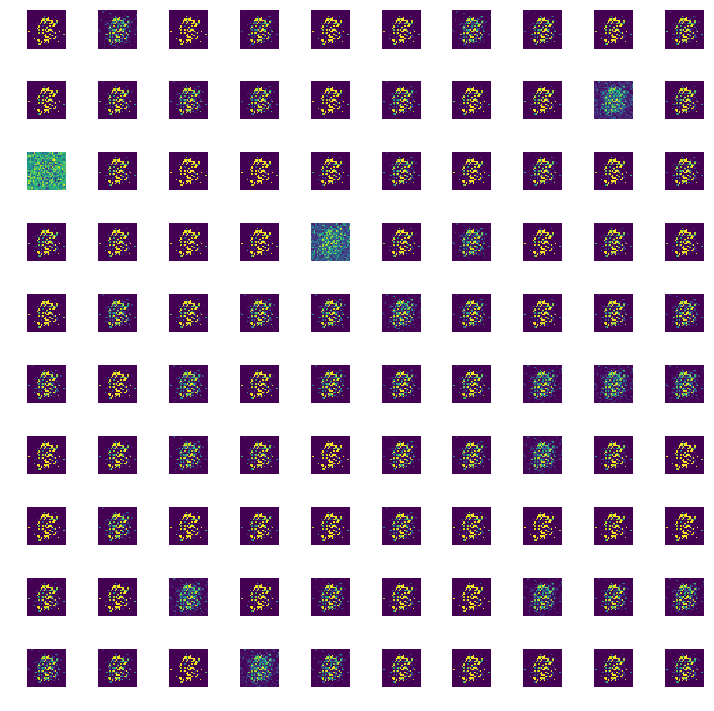

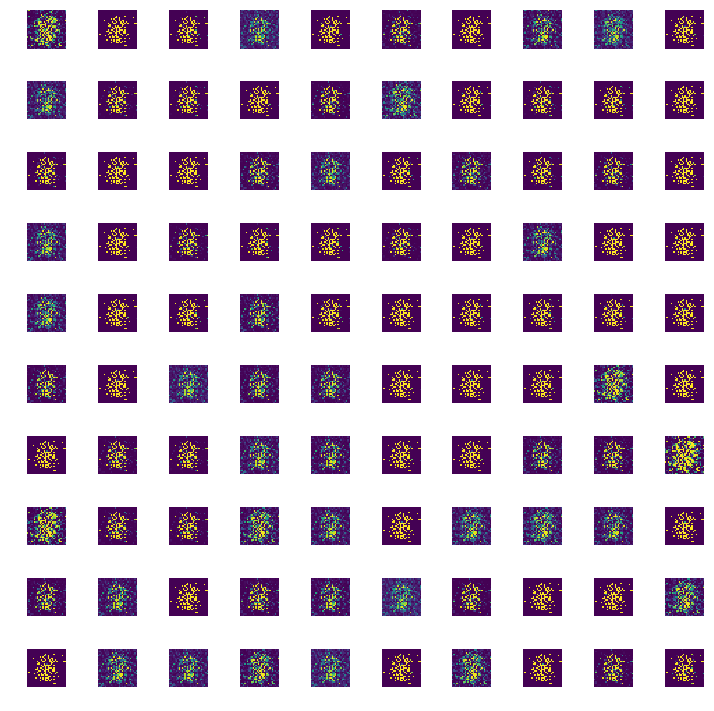

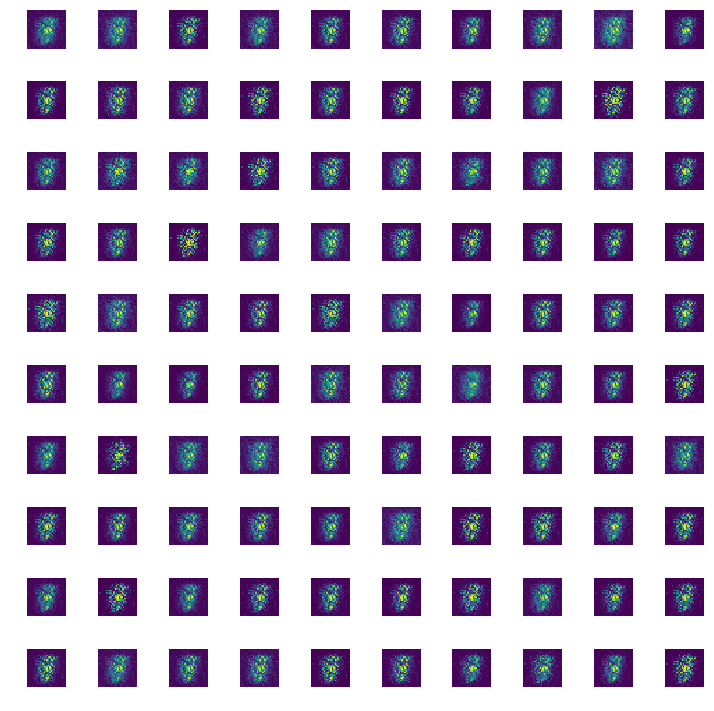

In [9]:
#do 400 epochs of training with batch sizes of 128
#each epoch will first train/improve the discriminator
#then train and improve the generator
#training(400, 128)
training(4,128)

In [ ]:
#if you finished the training, you should see pictures demonstrating how good are generator is at creating realistic looking images from noise
#we alos probably have a pretty good discriminator at the end of training, if that's of interest to you
#i wonder what distribution of numbers the generator produces. is it the same as the real MNIST training data distribution?